# Análisis exploratorio de datos (EDA) con las imágenes procesadas Sentinel-1
En este notebook vamos a cargar las imágenes que fueron procesadas para obtener:
1. Intensidades de retroesparcimiento ($\alpha^0$ y $\gamma^0$) en VV y VH -> **20 capas**
2. Indice de vegetación de Radar Dual dpRVI -> **5 capas**
3. Descomposición H-a-$\alpha$ dual (Cloude-Pottier) -> **15 capas**

En tres raster multitemporales para las fechas **Febrero 19, Marzo 15, Abril 08, Mayo 26 y Junio 19** que están recortados a las parcelas G, Y y O.

# Cargar los puntos de muestreo

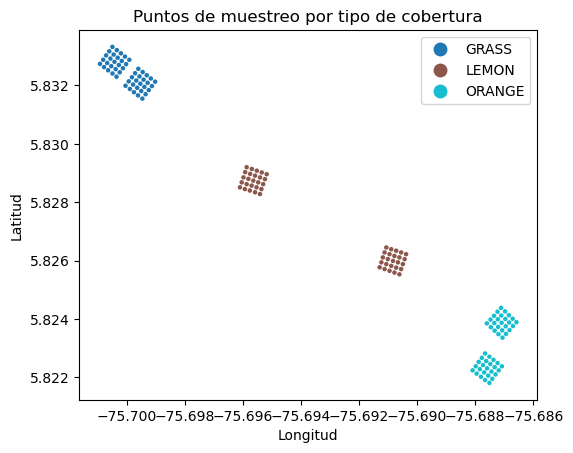

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Lee el Excel
df_points = pd.read_excel('C:/Users/Usuario/OneDrive/20211021_Int_Datafusion/20240118_MSc_MR_Datafusion/Database/excel/SamplingPoints.xlsx', sheet_name='Hoja1')

# Crea GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    df_points,
    geometry=[Point(xy) for xy in zip(df_points['long'], df_points['lat'])],
    crs="EPSG:4326" # Cambia si tus rasters están en otra proyección
)

# Grafica los puntos coloreados por el atributo 'cover'
import matplotlib.pyplot as plt
gdf_points.plot(column='cover', legend=True, marker='o', markersize=5)
plt.title('Puntos de muestreo por tipo de cobertura')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [2]:
df_points.head()

,No,cover,cov_abrev,rep,id_parcel,id_point,lat,long
0,1,GRASS,G,1,G1,G1-1,5.83274,-75.70092
1,2,GRASS,G,1,G1,G1-2,5.83263,-75.70078
2,3,GRASS,G,1,G1,G1-3,5.83252,-75.70064
3,4,GRASS,G,1,G1,G1-4,5.83241,-75.70049
4,5,GRASS,G,1,G1,G1-5,5.83230,-75.70035


# Visualizacion de las imágenes con los puntos de muestreo

In [2]:
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import os

def plot_raster_patch_with_points(
    gdf_parcela, 
    raster_folder, 
    raster_dict, 
    parcela_col='id_parcel',
    id_col='id_point',
    figsize=(8,8)
):
    """
    Visualiza el parche de cada raster de parcela junto con sus puntos de muestreo.
    raster_dict: {'G1': 'G1_SAR_stack.tif', ...}
    """

    for parcela, raster_name in raster_dict.items():
        path_raster = os.path.join(raster_folder, raster_name)
        if not os.path.exists(path_raster):
            print(f'Raster {path_raster} no encontrado')
            continue
        
        # Selecciona puntos de la parcela
        gdf_parcela = gdf_points[gdf_points[parcela_col] == parcela].copy()
        if gdf_parcela.empty:
            print(f'No hay puntos para {parcela}')
            continue

        with rasterio.open(path_raster) as src:
            # Lee la primera banda (por default), puedes cambiarla si quieres otra
            image = src.read(1)
            bounds = src.bounds
            extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
            # Proyecta puntos si es necesario
            gdf_proj = gdf_parcela.to_crs(src.crs)
            
            # Plot
            plt.figure(figsize=figsize)
            plt.imshow(image, extent=extent, cmap='gray')
            plt.scatter(
                gdf_proj.geometry.x, gdf_proj.geometry.y,
                c='red', s=40, marker='o', label='Sampling points', edgecolor='k'
            )
            for idx, row in gdf_proj.iterrows():
                plt.text(row.geometry.x, row.geometry.y, str(row[id_col]), fontsize=8, color='yellow')
            property = os.path.basename(raster_folder)
            plt.title(f'Raster: {property} Plot: {parcela}\n{raster_name}')
            plt.xlabel('Coord X')
            plt.ylabel('Coord Y')
            plt.legend()
            plt.tight_layout()
            plt.show()


## dpRVI

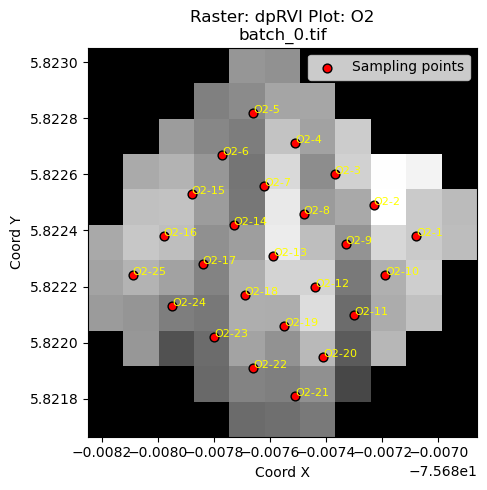

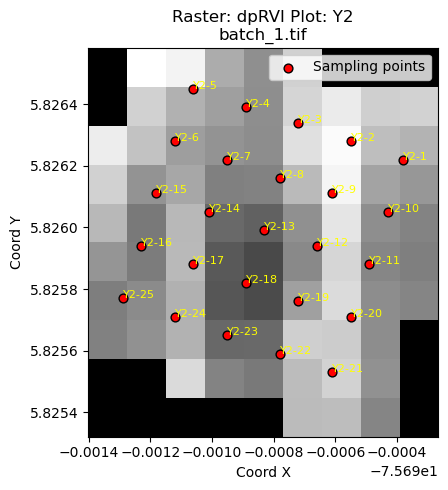

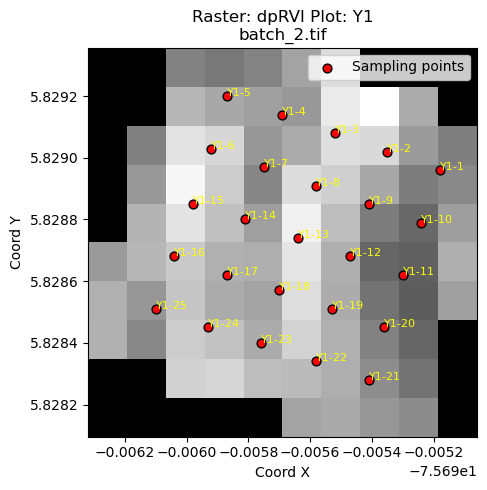

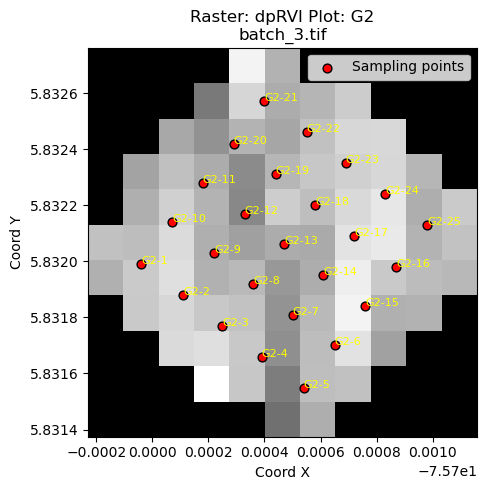

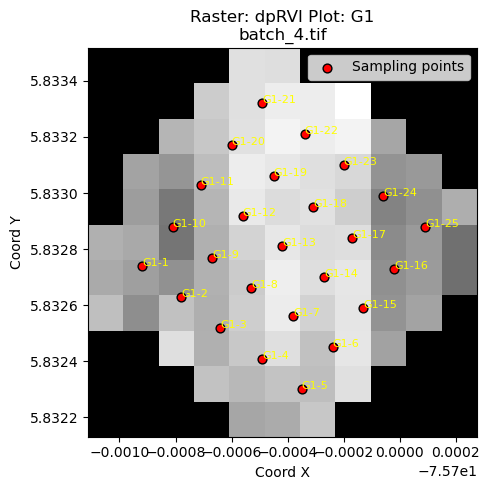

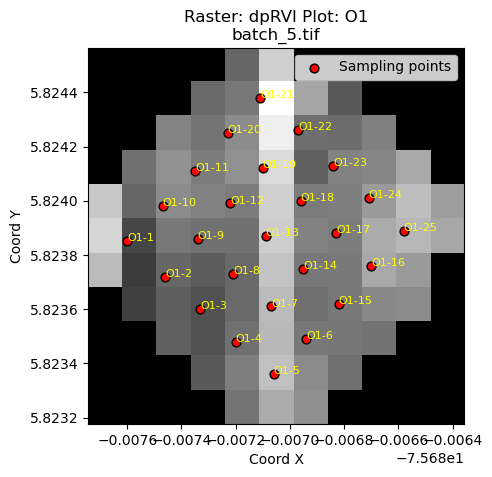

In [3]:
raster_dict = {
    'O2': 'batch_0.tif',
    'Y2': 'batch_1.tif',
    'Y1': 'batch_2.tif',
    'G2': 'batch_3.tif',
    'G1': 'batch_4.tif',
    'O1': 'batch_5.tif',
}

plot_raster_patch_with_points(
    gdf_parcela=gdf_points,
    raster_folder='../processed/2025-0218-0619/batches_offset/dpRVI',
    raster_dict=raster_dict,
    figsize=(5, 5)
    )

## H-a-$\alpha$

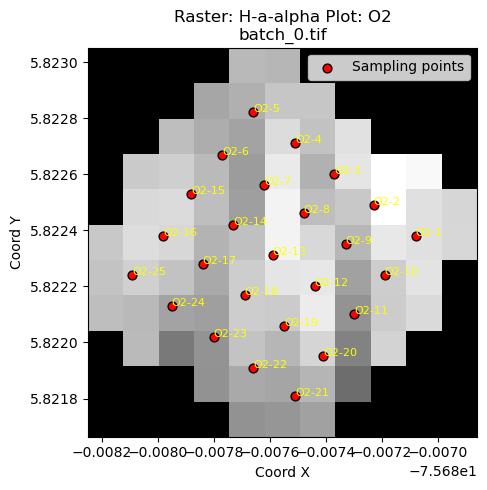

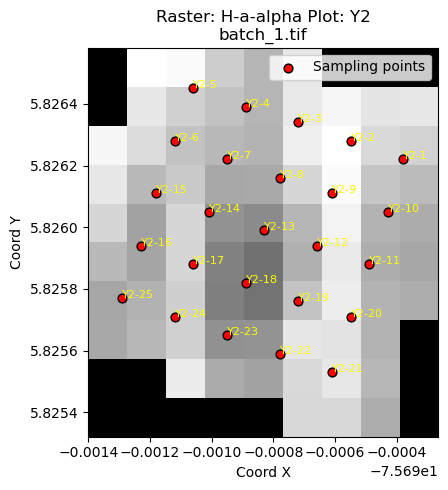

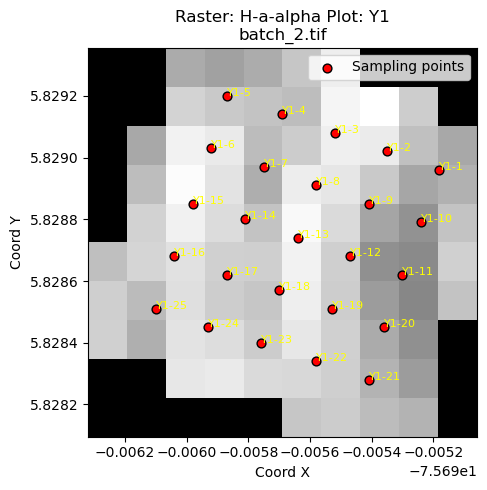

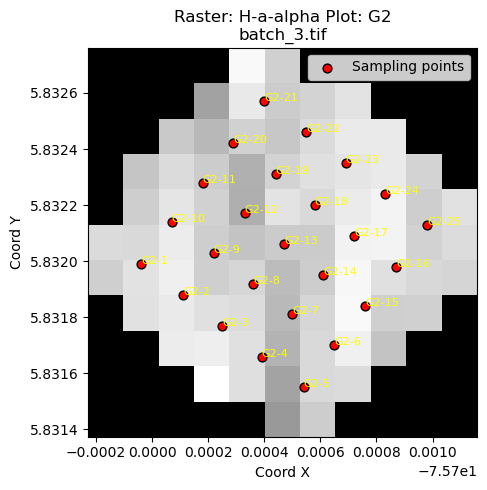

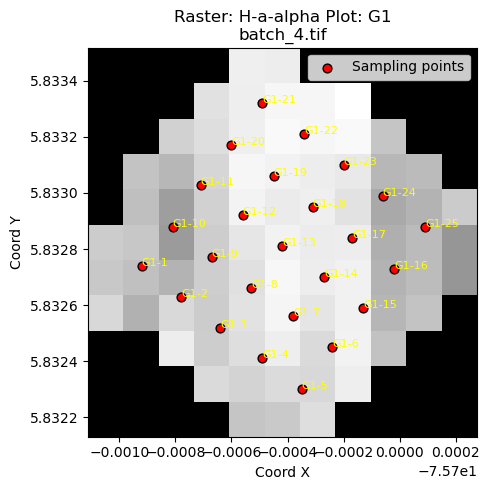

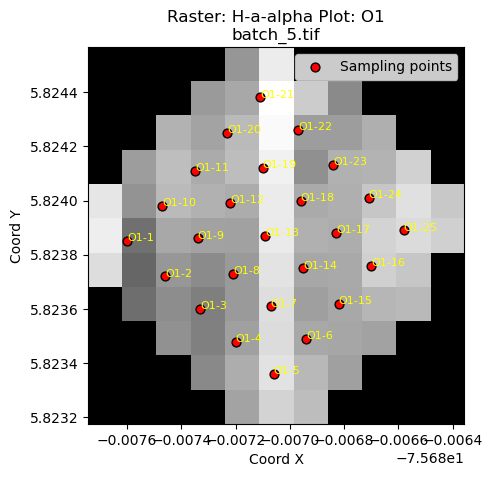

In [4]:
plot_raster_patch_with_points(
    gdf_parcela=gdf_points,
    raster_folder='../processed/2025-0218-0619/batches_offset/H-a-alpha',
    raster_dict=raster_dict,
    figsize=(5, 5)
    )

## Backscatter intensity

In [7]:
# Preprocesamiento de datos de intensidad de retrodispersión
# conversión a dB y normalización
def convert_to_db_and_normalize(raster_folder, raster_dict):
    """
    Convierte los rasters de retrodispersión a dB y normaliza.
    raster_dict: {'G1': 'G1_SAR_stack.tif', ...}
    """
    for parcela, raster_name in raster_dict.items():
        path_raster = os.path.join(raster_folder, raster_name)
        if not os.path.exists(path_raster):
            print(f'Raster {path_raster} no encontrado')
            continue
        
        with rasterio.open(path_raster) as src:
            image = src.read(1).astype(np.float32)
            # Convertir a dB
            image_db = 10 * np.log10(image + 1e-10)  # Evitar log(0)
            # Normalizar entre 0 y 1
            image_norm = (image_db - np.min(image_db)) / (np.max(image_db) - np.min(image_db))
            
            # Guardar el nuevo raster
            new_raster_name = raster_name
            new_raster_folder = os.path.join(raster_folder, 'intensities_db_normalized')
            os.makedirs(new_raster_folder, exist_ok=True)
            new_path = os.path.join(new_raster_folder, new_raster_name)
            with rasterio.open(new_path, 'w', driver='GTiff', height=image_norm.shape[0], width=image_norm.shape[1],
                               count=1, dtype=image_norm.dtype, crs=src.crs, transform=src.transform) as dst:
                dst.write(image_norm, 1)
                
            print(f'Raster {new_path} guardado con normalización y conversión a dB.')

convert_to_db_and_normalize(
    raster_folder='../processed/2025-0218-0619/batches/backscatter_intensities',
    raster_dict=raster_dict
)


Raster ../processed/2025-0218-0619/batches/backscatter_intensities\intensities_db_normalized\batch_0.tif guardado con normalización y conversión a dB.
Raster ../processed/2025-0218-0619/batches/backscatter_intensities\intensities_db_normalized\batch_1.tif guardado con normalización y conversión a dB.
Raster ../processed/2025-0218-0619/batches/backscatter_intensities\intensities_db_normalized\batch_2.tif guardado con normalización y conversión a dB.
Raster ../processed/2025-0218-0619/batches/backscatter_intensities\intensities_db_normalized\batch_3.tif guardado con normalización y conversión a dB.
Raster ../processed/2025-0218-0619/batches/backscatter_intensities\intensities_db_normalized\batch_4.tif guardado con normalización y conversión a dB.
Raster ../processed/2025-0218-0619/batches/backscatter_intensities\intensities_db_normalized\batch_5.tif guardado con normalización y conversión a dB.


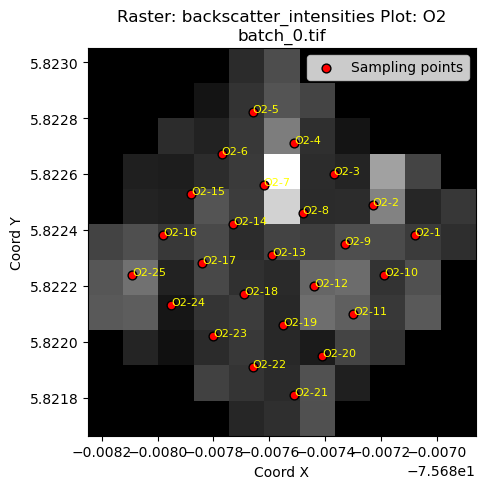

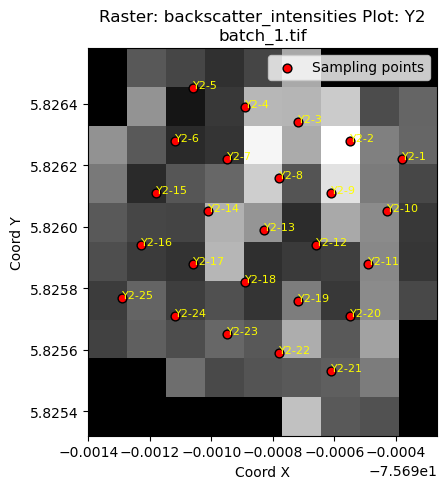

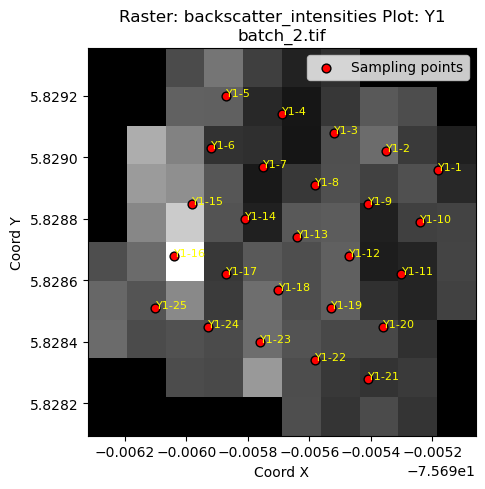

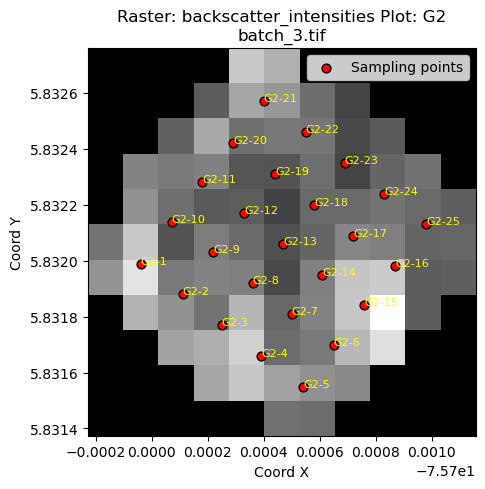

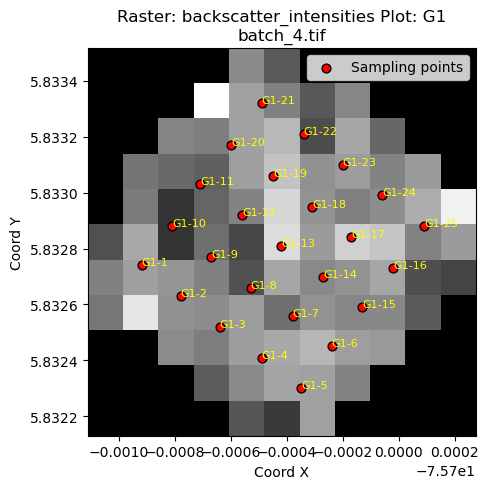

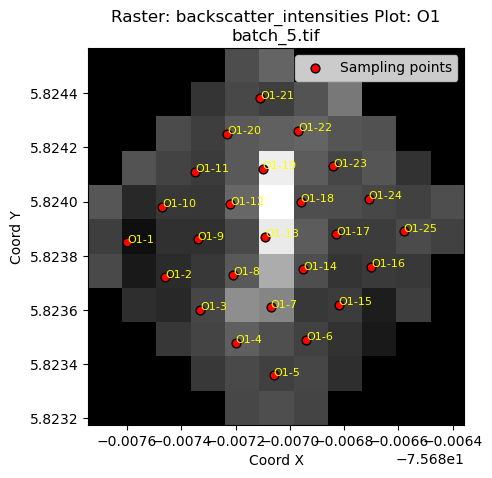

In [5]:
plot_raster_patch_with_points(
    gdf_parcela=gdf_points,
    raster_folder='../processed/2025-0218-0619/batches_offset/backscatter_intensities',
    raster_dict=raster_dict,
    figsize=(5, 5)
    )

# Extraer valores SAR de los rásters por punto
## Funcion

In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import os

def extract_SAR_values_per_parcel(
    gdf_points, 
    raster_folder, 
    raster_dict, 
    band_dict,
    parcela_col='id_parcel',
    output_csv='SAR_points_extracted.csv'
):
    """
    Extrae valores de los rasters SAR para los puntos de muestreo de cada parcela,
    usando diccionario de nombres de bandas, y guarda un archivo .csv final.
    
    points_excel: path al archivo Excel con puntos de muestreo
    sheet_points: nombre de la hoja con los puntos (debe incluir columnas: Parcela, Lat, Lon, ID_punto, etc.)
    raster_folder: carpeta donde están los rasters recortados (uno por parcela)
    raster_dict: diccionario {'G1': 'G1_SAR_stack.tif', ...} de archivos por parcela
    band_dict: diccionario de nombres de bandas según el orden en el raster
    output_csv: nombre del archivo de salida
    
    Devuelve un dataframe con todos los valores.
    """

    # 1. Extraer los valores por parcela
    all_results = []
    for parcela, raster_name in raster_dict.items():
        path_raster = os.path.join(raster_folder, raster_name) # Accede al raster por parcela
        # Filtra los puntos de esa parcela gracias al diccionario
        gdf_parcela = gdf_points[gdf_points[parcela_col] == parcela].copy()
        if gdf_parcela.empty:
            continue
        # Extrae valores para todos los puntos de esa parcela
        with rasterio.open(path_raster) as src:
            gdf_parcela = gdf_parcela.to_crs(src.crs) # reproyecta para encajar con el CRS del raster
            coords = [(pt.x, pt.y) for pt in gdf_parcela.geometry]
            bands_data = []
            for idx in range(1, src.count + 1):
                vals = [val[0] for val in src.sample(coords, indexes=idx)] # Extrae valores de la banda idx usando interpolación
                band_name = band_dict.get(f'Banda {idx:02d}', f'Banda {idx:02d}') # Convierte el nombre de banda según el diccionario para mejor intepretación
                bands_data.append((band_name, vals)) # Agrega el nombre de la banda y sus valores a la lista
            # Construye DataFrame
            for i, (band_name, vals) in enumerate(bands_data):
                gdf_parcela[band_name] = vals
            all_results.append(gdf_parcela)
    # 3. Unir resultados y exportar
    df_all = pd.concat(all_results, ignore_index=True)
    # Eliminar las columnas no relevantes
    columns_to_keep = [col for col in df_all.columns if col not in ['No', 'cover', 'cov_abrev', 'rep', 'id_parcel', 'lat', 'long', 'geometry']]
    df_all = df_all[columns_to_keep]
    # Exporta a CSV
    df_all.to_csv(output_csv, index=False)
    return df_all


## Diccionarios de bandas

In [7]:
# Diccionarios de los nombres de las bandas
dprvi_band_dict = {
    'Banda 01': 'dpRVI_19Feb2025',
    'Banda 02': 'dpRVI_15Mar2025',
    'Banda 03': 'dpRVI_08Apr2025',
    'Banda 04': 'dpRVI_26May2025',
    'Banda 05': 'dpRVI_19Jun2025'
}

haalpha_band_dict = {
    'Banda 01': 'Entropy_19Feb2025',
    'Banda 02': 'Anisotropy_19Feb2025',
    'Banda 03': 'Alpha_19Feb2025',
    'Banda 04': 'Entropy_15Mar2025',
    'Banda 05': 'Anisotropy_15Mar2025',
    'Banda 06': 'Alpha_15Mar2025',
    'Banda 07': 'Entropy_08Apr2025',
    'Banda 08': 'Anisotropy_08Apr2025',
    'Banda 09': 'Alpha_08Apr2025',
    'Banda 10': 'Entropy_26May2025',
    'Banda 11': 'Anisotropy_26May2025',
    'Banda 12': 'Alpha_26May2025',
    'Banda 13': 'Entropy_19Jun2025',
    'Banda 14': 'Anisotropy_19Jun2025',
    'Banda 15': 'Alpha_19Jun2025'
}

intensity_band_dict = {
    'Banda 01': 'Sigma0_VH_19Feb2025',
    'Banda 02': 'Sigma0_VV_19Feb2025',
    'Banda 03': 'Gamma0_VH_19Feb2025',
    'Banda 04': 'Gamma0_VV_19Feb2025',
    'Banda 05': 'Sigma0_VH_15Mar2025',
    'Banda 06': 'Sigma0_VV_15Mar2025',
    'Banda 07': 'Gamma0_VH_15Mar2025',
    'Banda 08': 'Gamma0_VV_15Mar2025',
    'Banda 09': 'Sigma0_VH_08Apr2025',
    'Banda 10': 'Sigma0_VV_08Apr2025',
    'Banda 11': 'Gamma0_VH_08Apr2025',
    'Banda 12': 'Gamma0_VV_08Apr2025',
    'Banda 13': 'Sigma0_VH_26May2025',
    'Banda 14': 'Sigma0_VV_26May2025',
    'Banda 15': 'Gamma0_VH_26May2025',
    'Banda 16': 'Gamma0_VV_26May2025',
    'Banda 17': 'Sigma0_VH_19Jun2025',
    'Banda 18': 'Sigma0_VV_19Jun2025',
    'Banda 19': 'Gamma0_VH_19Jun2025',
    'Banda 20': 'Gamma0_VV_19Jun2025',
}

## Ejecucion y unión

In [8]:
# Intensity
df_intensity = extract_SAR_values_per_parcel(
    gdf_points=gdf_points,
    raster_folder='../processed/2025-0218-0619/batches_offset/backscatter_intensities',
    raster_dict=raster_dict,
    band_dict=intensity_band_dict,
    output_csv='outputs/Tabla_SAR_Intensity.csv'
)

# H-a-alpha
df_haalpha = extract_SAR_values_per_parcel(
    gdf_points=gdf_points,
    raster_folder='../processed/2025-0218-0619/batches_offset/H-a-alpha',
    raster_dict=raster_dict,
    band_dict=haalpha_band_dict,
    output_csv='outputs/Tabla_SAR_HAAlpha.csv'
)

# dpRVI
df_dprvi = extract_SAR_values_per_parcel(
    gdf_points=gdf_points,
    raster_folder='../processed/2025-0218-0619/batches_offset/dpRVI',
    raster_dict=raster_dict,
    band_dict=dprvi_band_dict,
    output_csv='outputs/Tabla_SAR_dpRVI.csv'
)


### Cálculo de co-polarizaión de intensidad

In [9]:
import re
import numpy as np
import pandas as pd

def _db_to_lin(x):
    return 10.0 ** (x / 10.0)

def _lin_to_db(x):
    # Evita -inf si hay ceros numéricos
    x = np.where(x <= 0, np.nan, x)
    return 10.0 * np.log10(x)

def compute_cross_pol_metrics(
    df_intensity: pd.DataFrame,
    id_cols=('id_point'),
    in_db=True,
    output_db=False,
    products=('Sigma0','Gamma0')
):
    """
    Calcula VH+VV y VH/VV por fecha para cada producto (Sigma0 y/o Gamma0).
    
    Requisitos de nombres de columnas en df_intensity:
      - Deben incluir el producto ("Sigma0" o "Gamma0"),
        la polarización ("VH" o "VV") y un token de fecha
        (p.ej. '19Feb2025', '2025-02-19', '2025_02_19', etc.).
      - Ejemplos: 'Sigma0_IW1_VH_mst_19Feb2025', 'Gamma0_IW1_VV_slv4_08Apr2025', ...
    
    Parámetros:
      df_intensity : DataFrame con columnas de intensidades multitemporales
      id_cols      : columnas de identificación que se copian al resultado
      in_db        : True si las intensidades están en dB (se convierten a lineal para operar)
      output_db    : True si quieres que la salida (sum y ratio) quede en dB
      products     : ('Sigma0','Gamma0') o subset ('Sigma0',) etc.
    
    Retorna:
      df_cross_pol : DataFrame con id_cols + columnas nuevas:
         <Producto>_SUM_VHVV_<fecha>, <Producto>_RATIO_VH_VV_<fecha>
    """
    df = df_intensity.copy()

    # Asegura presencia de id_cols (si alguna falta, se ignora silenciosamente)
    id_cols_present = [c for c in id_cols if c in df.columns]
    out = df[id_cols_present].copy()

    # Patrón para extraer info de cada columna (Producto, Pol, Fecha)
    # Captura fechas en varios formatos: 19Feb2025 | 2025-02-19 | 2025_02_19 | 20250219
    date_pat = r'(\d{2}[A-Za-z]{3}\d{4}|\d{4}[-_]\d{2}[-_]\d{2}|\d{8})'
    col_regex = re.compile(
        rf'(?P<prod>{"|".join(products)})[^A-Za-z0-9]+(?P<pol>VH|VV).*?(?P<date>{date_pat})',
        flags=re.IGNORECASE
    )

    # Indexa columnas por (prod, date, pol)
    buckets = {}  # {(prod, date): {'VH': colname, 'VV': colname}}
    for col in df.columns:
        m = col_regex.search(col)
        if not m:
            continue
        prod = m.group('prod')
        pol  = m.group('pol').upper()
        date = m.group('date')
        key = (prod, date)
        buckets.setdefault(key, {})
        buckets[key][pol] = col

    # Recorre pares (VH,VV) por cada (prod,date) encontrados
    new_cols = {}
    for (prod, date), polmap in buckets.items():
        if 'VH' not in polmap or 'VV' not in polmap:
            continue  # pares incompletos no se usan

        col_vh = polmap['VH']
        col_vv = polmap['VV']

        vh = df[col_vh].astype(float)
        vv = df[col_vv].astype(float)

        if in_db:
            vh_lin = _db_to_lin(vh)
            vv_lin = _db_to_lin(vv)
        else:
            vh_lin = vh.values
            vv_lin = vv.values

        # Suma y ratio en lineal
        sum_lin   = vh_lin + vv_lin
        ratio_lin = vh_lin / np.where(vv_lin == 0, np.nan, vv_lin)

        if output_db:
            sum_val   = _lin_to_db(sum_lin)
            ratio_val = _lin_to_db(ratio_lin)
        else:
            sum_val   = sum_lin
            ratio_val = ratio_lin

        sum_name   = f'{prod}_SUM_VHVV_{date}'
        ratio_name = f'{prod}_RATIO_VH_VV_{date}'
        new_cols[sum_name]   = sum_val
        new_cols[ratio_name] = ratio_val

    # Anexa nuevas columnas al DataFrame de salida
    for k, v in new_cols.items():
        out[k] = v

    # Ordena columnas: id_cols primero
    other_cols = [c for c in out.columns if c not in id_cols_present]
    out = out[id_cols_present + sorted(other_cols)]

    # Devuelve con el nombre solicitado
    df_cross_pol = out
    return df_cross_pol

# Ejecuta la función
df_cross_pol = compute_cross_pol_metrics(df_intensity, id_cols=('id_point'), 
                                         in_db=False, # True si las intensidades están en decibelios
                                         output_db=False, # True si quieres que la salida quede en decibelios
                                         products=('Sigma0','Gamma0'))

# Exporta a csv
df_cross_pol.to_csv('outputs/Tabla_SAR_CrosPol_Intensities.csv', index=False)


In [10]:
# Concatena resultados con df_intensity
df_intensity = pd.concat([df_intensity, df_cross_pol], axis=1)

In [11]:
from functools import reduce

df_pixel_values = [df_intensity, df_haalpha, df_dprvi]
df_merged = reduce(lambda left, right: pd.merge(
    left, right, 
    on=['id_point'],  # Usa las columnas comunes
    how='outer'
), df_pixel_values)
# Exportar a CSV
df_merged.to_csv('outputs/SAR_values.csv', index=False)
# Exportar a excel
df_merged.to_excel('outputs/SAR_values.xlsx', index=False)  # Exporta a Excel


Archivo: batch_0.tif
Dimensiones: 9 x 9
CRS: EPSG:4326
Transformación: | 0.00, 0.00,-75.69|
| 0.00,-0.00, 5.82|
| 0.00, 0.00, 1.00|

Archivo: batch_1.tif
Dimensiones: 9 x 8
CRS: EPSG:4326
Transformación: | 0.00, 0.00,-75.69|
| 0.00,-0.00, 5.83|
| 0.00, 0.00, 1.00|

Archivo: batch_2.tif
Dimensiones: 8 x 8
CRS: EPSG:4326
Transformación: | 0.00, 0.00,-75.70|
| 0.00,-0.00, 5.83|
| 0.00, 0.00, 1.00|

Archivo: batch_3.tif
Dimensiones: 9 x 9
CRS: EPSG:4326
Transformación: | 0.00, 0.00,-75.70|
| 0.00,-0.00, 5.83|
| 0.00, 0.00, 1.00|

Archivo: batch_4.tif
Dimensiones: 9 x 9
CRS: EPSG:4326
Transformación: | 0.00, 0.00,-75.70|
| 0.00,-0.00, 5.83|
| 0.00, 0.00, 1.00|

Archivo: batch_5.tif
Dimensiones: 9 x 9
CRS: EPSG:4326
Transformación: | 0.00, 0.00,-75.69|
| 0.00,-0.00, 5.82|
| 0.00, 0.00, 1.00|



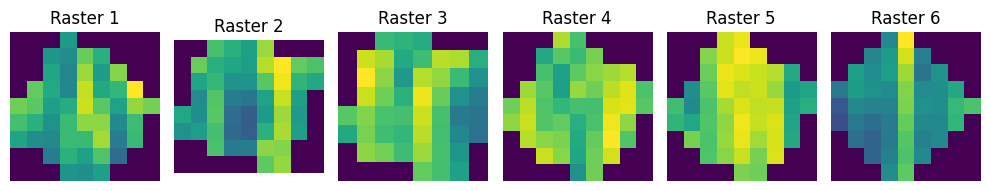

In [ ]:
# Cargar los raster dentro de un directorio y mostrar en el mapa
import os
import rasterio

path = '../processed/2025-0218-0619/batches/'
folder = 'dpRVI'

# Iniciar figura para graficar
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Crear una lista para almacenar los archivos raster
raster_files = []
for file in os.listdir(os.path.join(path, folder)):
    if file.endswith('.tif'):
        file_path = os.path.join(path, folder, file)
        with rasterio.open(file_path) as src:
            print(f"Archivo: {file}")
            print(f"Dimensiones: {src.width} x {src.height}")
            print(f"CRS: {src.crs}")
            print(f"Transformación: {src.transform}")
            # Imprimir el numero de bandas
            print(f"Número de bandas: {src.count}")
            print()  # Línea en blanco para mejor legibilidad
            #raster_files.append(src.read(1)) # Leer la primera banda del raster
            plt.subplot

# Graficar los datos raster

for i, raster in enumerate(raster_files):
    plt.subplot(1, len(raster_files), i + 1)
    plt.imshow(raster, cmap='viridis')
    plt.title(f'Raster {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()           
            
